<h1><center><font size="6">Globant Diabetes Test Description</font></center></h1>

## Problem Statement

In this dataset you have 3 different outputs:
1. No readmission;
2. A readmission in less than 30 days (this situation is not good, because maybe
your treatment was not appropriate);
3. A readmission in more than 30 days (this one is not so good as well the last
one, however, the reason could be the state of the patient.

Your task is either to classify a patient-hospital outcome or to cluster them aiming at
finding patterns that give a distinct insight.
To do so, we suggest you create a notebook, like Jupyter (if you use python) or a
Rmarkdown report (in case you use R) and make it available for us, i.e. github.
Hint to success in your quest: Develop and stay clear of the data science process you'll
perform over the dataset and highlight important aspects you might consider affordable
to discuss over.
You have up to a day before the technical interview to share your results of this test.
Good luck.

# <a id='0'>Table of Contents</a>

1. [Data set description](#setup1)<br>
2. [Data Exploration](#explore)<br>
    2.1 [Exploratory Data Analysis (EDA)](#explore1)<br>
    2.2 [Feature Engineering: Grouping](#explore2)<br>
    2.3 [Feature Engineering: Encoding](#explore3)<br>
    2.4 [Principal Component Analysis](#explore4)<br>
3. [Modeling](#modeling)<br>
4. [Conclusions](#con)<br>
5. [Additional: Clustering](#cluster)<br>

### 1. Data set description <a id="setup1"></a>

The data set has records from 130 US hospitals in a time span of 10 years from 1999 to 2008. It has been prepared to analyze factors related to readmission as well as other outcomes pertaining to patients with diabetes. It includes over 50 features representing patient and hospital outcomes.

The [data](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#) are submitted on behalf of the Center for Clinical and Translational Research, Virginia Commonwealth University, a recipient of NIH CTSA grant UL1 TR00058 and a recipient of the CERNER data. John Clore (jclore '@' vcu.edu), Krzysztof J. Cios (kcios '@' vcu.edu), Jon DeShazo (jpdeshazo '@' vcu.edu), and Beata Strack (strackb '@' vcu.edu). This data is a de-identified abstract of the Health Facts database (Cerner Corporation, Kansas City, MO).

Information was extracted from the database for encounters that satisfied the following criteria.
* It is an inpatient encounter (a hospital admission).
* It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
* The length of stay was at least 1 day and at most 14 days.
* Laboratory tests were performed during the encounter.
* Medications were administered during the encounter.

### 1.1. Feature description

The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

Detail description in Table 1 of the paper [Impact of HbA1c Measurement on Hospital Readmission Rates](https://www.hindawi.com/journals/bmri/2014/781670/).

<center><b>Table 1</b></center>

<img src="data/images/features1.png" alt="Drawing" style="width: 800px;"/>
<img src="data/images/features2.png" alt="Drawing" style="width: 800px;"/>

### 1.2. Paper conlusions

Multivariable logistic regression was used to fit the relationship between the measurement of HbA1c and early readmission while controlling for covariates such as demographics, severity and type of the disease, and type of admission. Results show that the measurement of HbA1c was performed infrequently (18.4%) in the inpatient setting. The statistical model suggests that the relationship between the probability of readmission and the HbA1c measurement depends on the primary diagnosis. The data suggest further that the greater attention to diabetes reflected in HbA1c determination may improve patient outcomes and lower cost of inpatient care.

<a href="#0"><font size="1">Back to contents</font></a>

### 2. Data Exploration<a id="explore"></a>

In [1]:
# Impor the libraries needed for the project
import pandas as pd # data frame management
import numpy as np # matrix management
import matplotlib.pyplot as plt # visualization
import seaborn as sns # stylize visualizations
import os # file management

In [2]:
# Deactivate scientific notation
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [3]:
# Increase the number of rows and column that can be printed
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
path_to_files = "./data/dataset_diabetes/"
list_of_files = os.listdir(path_to_files)

In [5]:
list_of_files

['diabetic_data.csv', 'IDs_mapping.csv']

In [6]:
df1 = pd.read_csv(os.path.join(path_to_files,list_of_files[0]),
                 dtype={'admission_type_id':str}) # Read file 1 with 'admission_type_id' as categorical for future merge
df2 = pd.read_csv(os.path.join(path_to_files,list_of_files[1])) # read file 2

In [7]:
# Diabetic dataset dimensions, more than 100k records and 50 features
print(f"diabetic_data rows and columns: {df1.shape}")
print(f"IDs_mapping rows and columns: {df2.shape}")

diabetic_data rows and columns: (101766, 50)
IDs_mapping rows and columns: (67, 2)


In [8]:
print(f"diabetic_data missing values count: {df1.isna().sum().sum()}")
print(f"IDs_mapping missing values count: {df2.isna().sum().sum()}") 

diabetic_data missing values count: 0
IDs_mapping missing values count: 7


At first glance there are no missing values in the diabetic_data due to the fact the data set has been already prepared (later on we found out that the missing values are replaced by the symbol "?"). On the other hand the dataset IDs_mapping has 7 missing values but the number of admisison types in this set is greater than the number of admission types in the diabetic_data (rate of 32 to 8), so it is possible that after joining the tables it would not be missing descriptions. 

In [9]:
df= df1.merge(df2.drop_duplicates(subset=['admission_type_id']),how='left',on='admission_type_id') #Merging both data frames
print(f"diabetic_data with admission type descriptions, rows and columns: {df.shape}")

diabetic_data with admission type descriptions, rows and columns: (101766, 51)


In [10]:
df['description'].value_counts() # Admission type descriptions

Emergency        53990
Elective         18869
Urgent           18480
Not Available     4785
Not Mapped         320
Trauma Center       21
Newborn             10
Name: description, dtype: int64

There are no missing values after joining both sets. The set called "df" will be used in the exploratory data analysis.

<a href="#0"><font size="1">Back to contents</font></a>

### 2.1. Exploratory Data Analysis (EDA)<a id="explore1"></a>

There are 51 features in the data set, so the approach to analyze the data is dividing the features in two groups: numeric and non numeric.

* Numeric features

In [11]:
# Let us extract only the numerical features
# Admission type, discharge disposition and admission source were nominal in table 1 but are numerical in this sample
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data_numerics = df.select_dtypes(include=numerics)
num_cols = data_numerics.keys().tolist() # Numeric columns
df[num_cols].describe().transpose() # Describe the numerical columns statistics

,count,mean,std,min,25%,50%,75%,max
encounter_id,101766,165201646,102640296,12522,84961194,152388987,230270888,443867222
patient_nbr,101766,54330401,38696359,135,23413221,45505143,87545950,189502619
discharge_disposition_id,101766,4,5,1,1,1,4,28
admission_source_id,101766,6,4,1,1,7,7,25
time_in_hospital,101766,4,3,1,2,4,6,14
num_lab_procedures,101766,43,20,1,31,44,57,132
num_procedures,101766,1,2,0,0,1,2,6
num_medications,101766,16,8,1,10,15,20,81
number_outpatient,101766,0,1,0,0,0,0,42
number_emergency,101766,0,1,0,0,0,0,76


In [12]:
df[num_cols].nunique() # Number of unique values per numeric column 

encounter_id                101766
patient_nbr                  71518
discharge_disposition_id        26
admission_source_id             17
time_in_hospital                14
num_lab_procedures             118
num_procedures                   7
num_medications                 75
number_outpatient               39
number_emergency                33
number_inpatient                21
number_diagnoses                16
dtype: int64

With describe and nunique we discover that Encounter id works as the primary key and on the other hand, patient number it is repeated in some cases, this was mentioned in the article ("Almost 70,000 inpatient diabetes encounters were identified with sufficient detail for analysis"-[Impact of HbA1c Measurement on Hospital Readmission Rates](https://www.hindawi.com/journals/bmri/2014/781670/)).

Additionally, 'discharge disposition id' is a categorical variable and has 3 categories missing if we compare to Table 1. Also 1 admission type and 5 admission source categories are missing comparing to the Table 1. 

So we can state that the sample taken from the 70k inpatient encounters it is not stratified, does not meet the same characteristics represented in the Table 1. 

It is necessary to plot these variables to see the distribution of the categories in the sample:

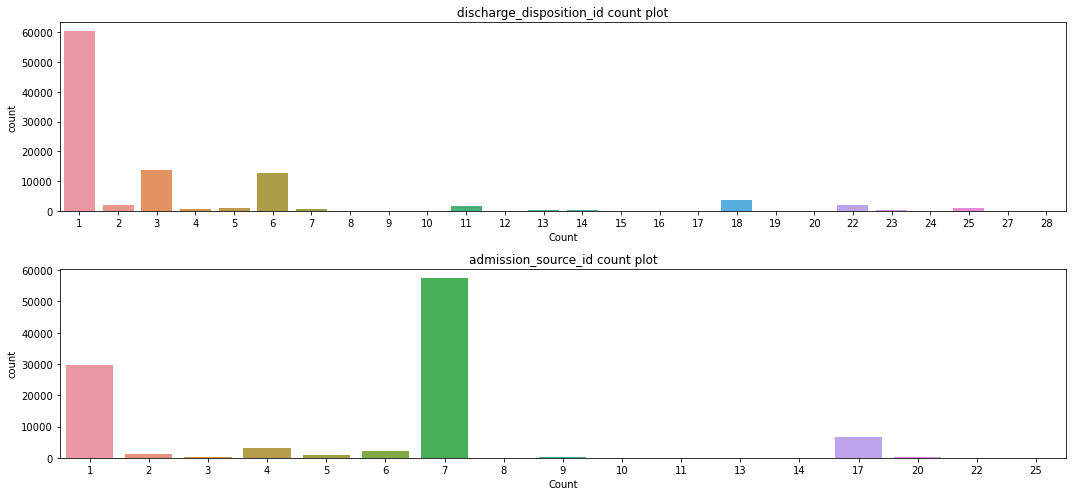

In [13]:
plt.figure(figsize=(15,7))
for i, var in enumerate(['discharge_disposition_id','admission_source_id']):
    plt.subplot(2,1,i+1)
    sns.countplot(x=var,data=df) # ,hue='readmitted')
    plt.xlabel("Count")
    plt.title(f"{var} count plot") 
plt.tight_layout()
plt.show()

The data is not balance, the majority of the data corresponds to 1 category. For 'discharge disposition' the type 1 has 60k records, this is more than half of the records in the data set. Also, 'admission source' has the category 7 close to 60k records and the category 1 close to 30k records, both categories represent more than 90% of the encounters.

* Non-numeric columns

In [14]:
# Non numeric columns
non_numeric_cols = [element for element in df.keys().tolist() if element not in data_numerics.keys().tolist()]

* Demographic - Race, Gender, Age
* Weight - Weight in pounds as ranges and mostly all of the records in the sample have unknown weight
* Payer code, medical speciality
* Diagnosis - diag_1: 848 distinct values, diag_2: 923 distinct values and diag_3: 954 distinct values - **Values from Table 1**
* Lab tests - max_glu_serum, A1Cresult
* Medicines - From metformin, repaglinide, ... metformin-rosiglitazone, metformin-pioglitazone
* Change - Binary feature - Indicates change in diabetic medications (either dosage or generic name)
* diabetesMed - Y/N if any diabetic medication was prescribed
* readmitted - Days to inpatient readmission - “No” for no record of readmission

#### Age, race, gender and weight

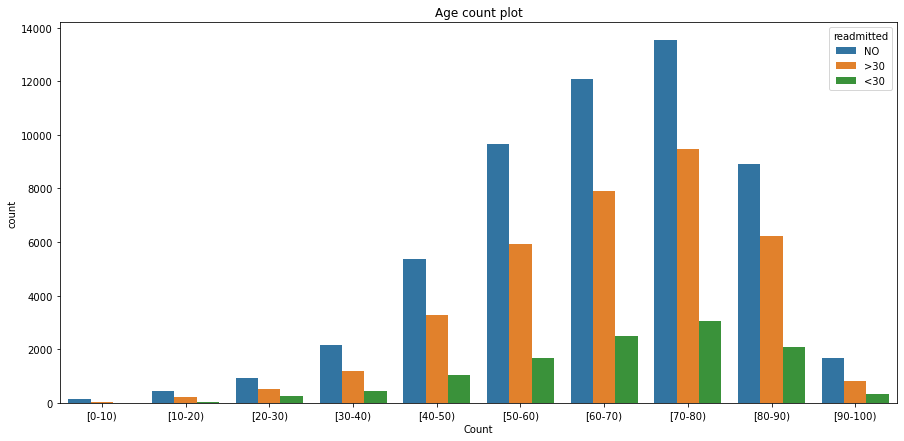

In [15]:
# Age count plot with readmitted labels
plt.figure(figsize=(15,7))
sns.countplot(x='age',data=df, hue='readmitted')
plt.xlabel("Count")
plt.title(f"Age count plot") 
plt.show()

We can see firstable that the age variable is not continuous and it is divided by groups. Secondly, that the distribution of the readmitted variable it is similar in all the age groups. And finally the distribution of the age in general it is skewed to the left, this could be explained by the fact that the amount of persons with diabetes it is greater as it goes older.

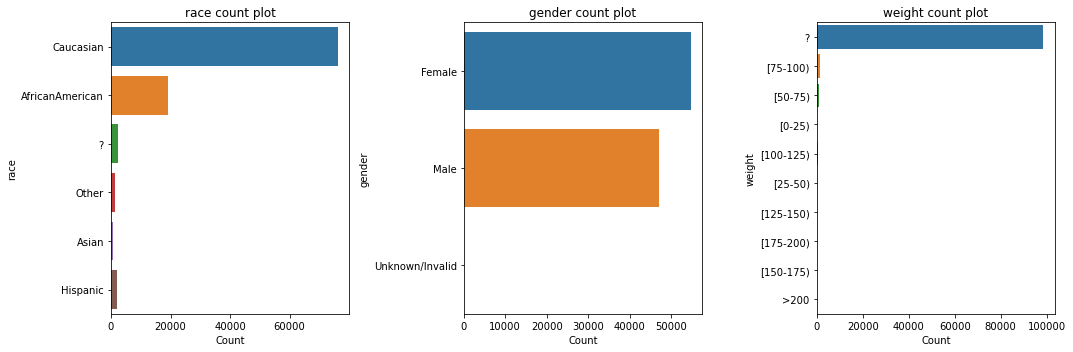

In [16]:
plt.figure(figsize=(15,5))
vars_to_plot= ['race','gender','weight']
for i, var in enumerate(vars_to_plot):
    plt.subplot(1,3,i+1)
    sns.countplot(y=var,data=df) # ,hue='readmitted'
    plt.xlabel("Count")
    plt.title(f"{var} count plot") 
plt.tight_layout()
plt.show()

Firstable, looking the race variable, there are more than 70k records associated to caucasian people and the other large group are the african americans close to 20k records. So both groups represent more than 90% of the data.

On the other hand, the distribution of the data analyzed by sex for inpatients with diabetes it is larger for females than males, and the records saved as unknown or invalid are lower than the 1%. 

Finally, unfortunately the weight variable that is known by medics to be correlated to diabetes it is really incomplete (More than 90% of the encounters have no recorded weight range).  

In [17]:
# Distribution of weight ranges without the unknowns 
df[df['weight']!='?']['weight'].value_counts()

[75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: weight, dtype: int64

#### Medical specialties and payer code

In [18]:
# Percentage of missing values for payer code
df[df['payer_code']=="?"].shape[0]*100/df.shape[0]

39.5574160328597

In [19]:
# Percentage of missing values for medical specialty
df[df['medical_specialty']=="?"].shape[0]*100/df.shape[0]

49.08220820313268

Medical specialty has almost 50% of missing data and on the other hand, payer code has almost 40%. Due to the fact these variables are categorical and have a large number of categories, use imputation methods after encoding would not be recommended. These variables could be used after removing the missing data and working with less than 50% of the data frame if needed. 

In [20]:
df[(df['medical_specialty']=="?")&(df['payer_code']=="?")].shape[0]*100/df.shape[0]

16.070200263349253

The percentage calculated before (16%), represent the data that have both features missing so there is not a great relationship in the missing information from those to variables. If we need to use them we should use them 1 at a time, in order to lose the least amount of data. 

In [21]:
# Looking for specialties related to diabetes
specialties = pd.Series(df['medical_specialty'].unique())
diabetes_specialties= specialties[(specialties.str.contains("Endo")==True)|(specialties.str.contains("Diet")==True)].values.tolist()
diabetes_specialties

['Pediatrics-Endocrinology', 'Endocrinology', 'Endocrinology-Metabolism']

In [22]:
# Function to determine if a record has a medical specialty related to diabetes 
def comparisson_diabetes_specialties(row):
    try:
        for i in diabetes_specialties:
            if i in row:
                a=1
                break
            else:
                a=0
        return int(a)
    
    except:
        a=np.nan
        return a

In [23]:
df['medical_specialty'].apply(comparisson_diabetes_specialties).value_counts()

0    101479
1       287
Name: medical_specialty, dtype: int64

The last value counts shows that the diabetes specialties selected are related to only 287 encounters.

#### Laboratory tests

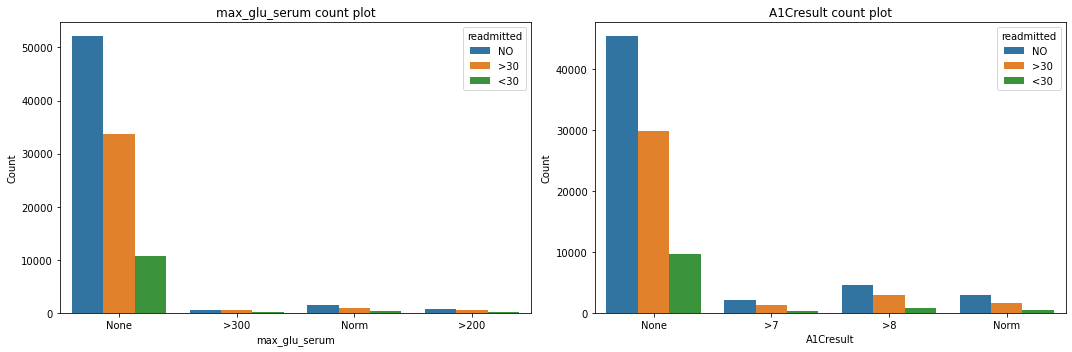

In [24]:
plt.figure(figsize=(15,5))
tests= ['max_glu_serum','A1Cresult']
for i, var in enumerate(tests):
    plt.subplot(1,2,i+1)
    sns.countplot(x=var,data=df,hue='readmitted')
    plt.ylabel("Count")
    plt.title(f"{var} count plot") 
plt.tight_layout()
plt.show()

* Random plasma glucose test

It is consider a normal value below 11.1 mmol/L or in other unit below 200 mg/dL ([link](https://dtc.ucsf.edu/types-of-diabetes/type2/understanding-type-2-diabetes/basic-facts/diagnosing-diabetes/)) 

In [25]:
df['max_glu_serum'].value_counts()

None    96420
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64

The greater amount of encounters didn't take the random plasma glucose test. The second value with the larger frequency is the normal range or below 200, follow by '>200' and finally '>300'. 

* HbA1c

Hemoglobin A1C: Glycated hemoglobin is a form of hemoglobin that is chemically linked to a sugar.

The second test measures HbA1c (Hemoglobin A1C). This is your average blood glucose (sugar) levels for the last two to three months. 

The normal range for HbA1c is 4 – 5.6% (20 – 38 mmol/mol) in healthy people; values between 5.7% and 6.4% (39 – 46 mmol/mol) point to prediabetes, while HbA1c over 6.5% (47 mmol/mol) may indicate diabetes ([link](https://labs.selfdecode.com/blog/hba1c-what-is-it-and-why-is-it-important/)).

In [26]:
df['A1Cresult'].value_counts()

None    84748
>8       8216
Norm     4990
>7       3812
Name: A1Cresult, dtype: int64

The greater amount of encounters didn't take the hemoglobin A1C test. Surprisingly the second value with the greater amount of frequency is greater to 8%, a very high value. 

#### Medicines related to diabetes 

In [27]:
# List of column names with medicines related to diabetes
meds = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide',
        'tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide',
        'citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone',
        'metformin-rosiglitazone','metformin-pioglitazone']

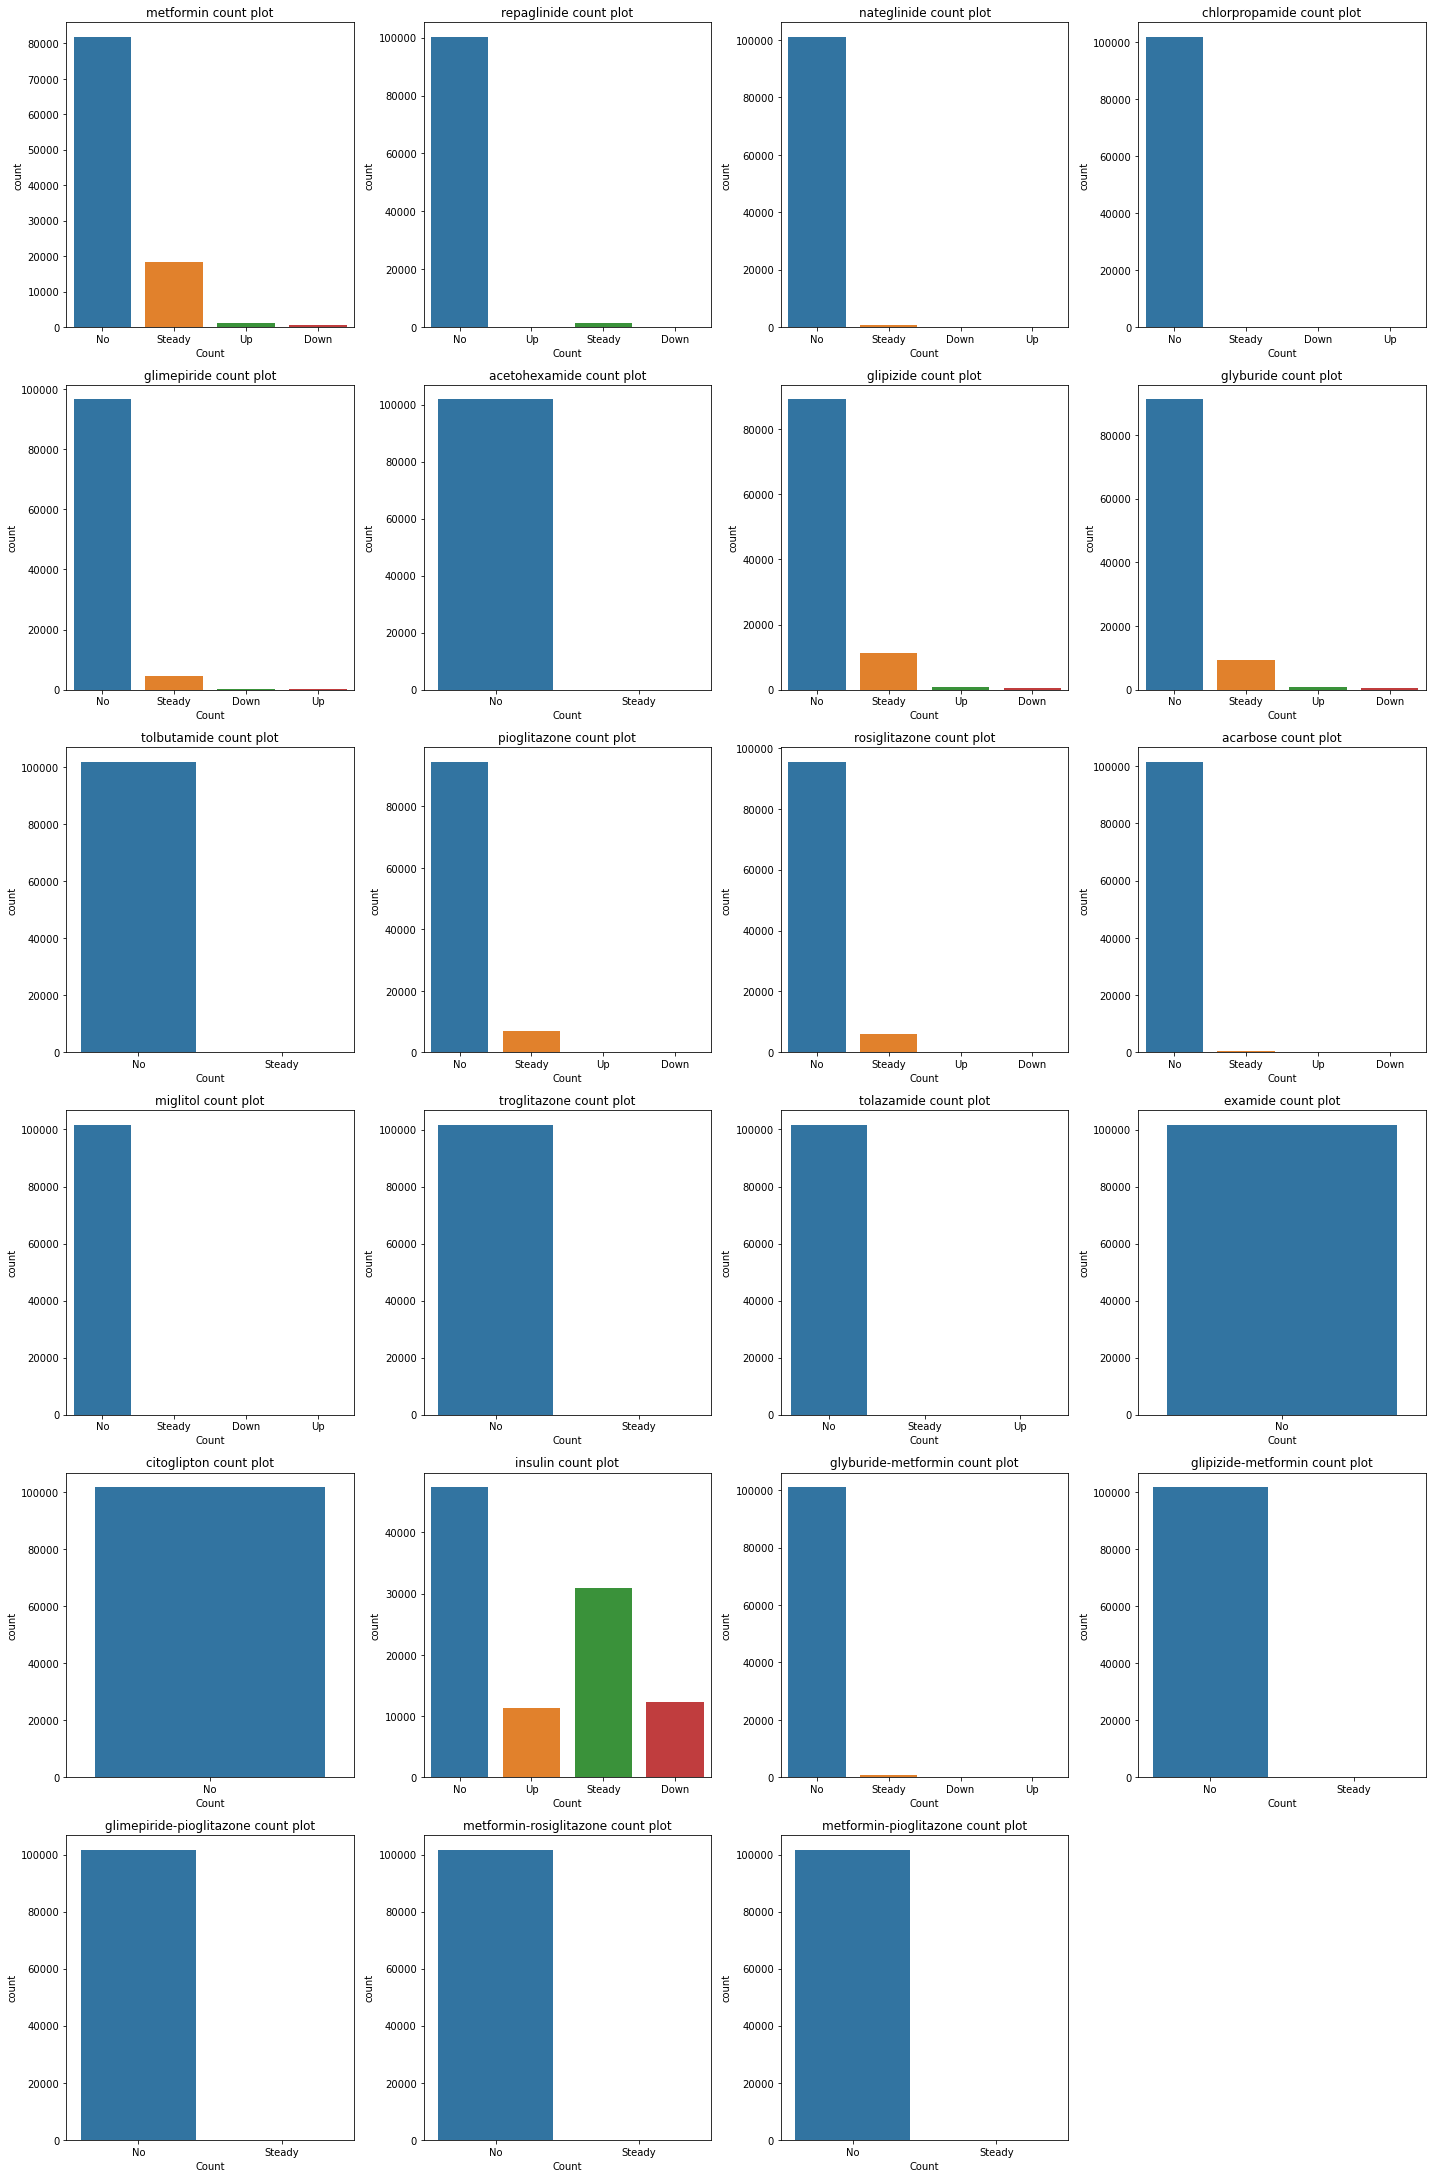

In [28]:
plt.figure(figsize=(20,40))
for i, var in enumerate(meds):
    plt.subplot(8,4,i+1)
    sns.countplot(x=var,data=df) # ,hue='readmitted'
    plt.xlabel("Count")
    plt.title(f"{var} count plot") 
plt.tight_layout()
plt.show()

Examide and citoglipton are not consumed by any patient (constant features for all sample). 
Aditionally there are 6 medicines with two categories: "No" and "Stedy", and almost all the records are "No". So it is important to review if the distribution of the target variable changes for those categories. 

In [29]:
# Activate 2 float numbers
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [30]:
# Crosstab analysis
def cross_tab(df,var):
    
    cross_df= pd.crosstab(index= df['readmitted'],columns= df[var], margins=True)
    cross_df['No(%)']= cross_df['No']*100/cross_df['No'][3]
    cross_df['Steady(%)']= cross_df['Steady']*100/cross_df['Steady'][3]
    print(cross_df)

In [31]:
# 6 medicines with two categories: "No" and "Stedy"
almost_zero_steady_meds = ['tolbutamide','troglitazone']+meds[-4:]

In [32]:
for i in almost_zero_steady_meds:
    cross_tab(df,i)        

tolbutamide      No  Steady     All  No(%)  Steady(%)
readmitted                                           
<30           11356       1   11357  11.16       4.35
>30           35538       7   35545  34.93      30.43
NO            54849      15   54864  53.91      65.22
All          101743      23  101766 100.00     100.00
troglitazone      No  Steady     All  No(%)  Steady(%)
readmitted                                            
<30            11357       0   11357  11.16       0.00
>30            35543       2   35545  34.93      66.67
NO             54863       1   54864  53.91      33.33
All           101763       3  101766 100.00     100.00
glipizide-metformin      No  Steady     All  No(%)  Steady(%)
readmitted                                                   
<30                   11356       1   11357  11.16       7.69
>30                   35538       7   35545  34.93      53.85
NO                    54859       5   54864  53.91      38.46
All                  101753      13 

All the records from the "Steady" category in the medicines 'metformin-rosiglitazone' and 'metformin-pioglitazone' have "NO" as the value of readmission. Additionally 'tolbutamide' has more percentage of "No readmission" in the "Steady" category than in the "No" category.

On the other hand, the other three medicines ('troglitazone','glipizide-metformin,'glimepiride-pioglitazone') have a distribution increase in the ">30" and "<30" for the "Steady" category. 

#### Change, diabetesMed and readmitted

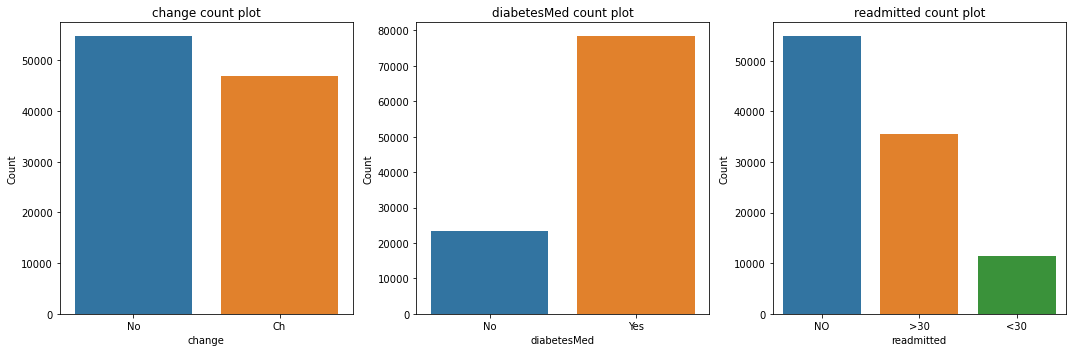

In [33]:
plt.figure(figsize=(15,5))
variables = ['change','diabetesMed','readmitted']
for i, var in enumerate(variables):
    plt.subplot(1,3,i+1)
    sns.countplot(x=var,data=df)
    plt.ylabel("Count")
    plt.title(f"{var} count plot") 
plt.tight_layout()
plt.show()

The variable that measures if the patient change medicines it is really balanced, diffenret to the 'diabetes med' indicator. taking into account that the data set is from inpatients with diabetes it is concerning that more than 20k are not taking medication (maybe due to low income - even though the payer codes distribution it is similar to for both categories).   

Our target variable is unbalanced but if we see this variable as "No" and "Yes" categories it is balanced. So there many options to tackle the prediction problem.

In [34]:
# Transform target variable in a binary variable
df['readmitted_reg']= df['readmitted'].apply(lambda x: 1 if x!="NO" else 0)

#### Outliers management

In statistics, an outlier is a data point that differs significantly from other observations. An outlier may be due to variability in the measurement or it may indicate experimental error.

Ocasionally the outliers are subjectives, and there are many numeric methods to classify them. The simplest method is **Tukey's range test** represented by the next equations:

`q < Q1 - 1.5 * IQR` or `q > Q3 + 1.5 * IQR`

Where **q** is the outlier, **Q1** is the first quartile (Is the median of the lower half of the data set. This means that about 25% of the numbers in the data set lie below Q1 and about 75% lie above Q1), **Q3** is the third quartile (75%) and **IQR** is the interquartile range `IQR = Q3 - Q1`.

In [35]:
#The next function calculate the limits supossing the values trusted as 1.5 times the interquartile range 
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
#The next function filter the dataset according the limits established in the functions above
def has_outliers(dataframe, num_col_names):
    variable_names = []
    new_df = dataframe.copy()
    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        if dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].any(axis=None):
            number_of_outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].shape[0]
            print("lower limit: {:.2f} - upper limit: {:.2f}".format(low_limit, up_limit))
            print("Outliers in", col.upper(), ":", number_of_outliers)
            variable_names.append(col)   
        new_df = new_df[(new_df[col] <= up_limit) & (new_df[col] >= low_limit)]
    print("Remaining rows: " + str(new_df.shape[0]))
    return new_df

In [36]:
print("Outlier count with Tukey's test\n")
df_tukey = has_outliers(df, num_cols[4:])

Outlier count with Tukey's test

lower limit: -4.00 - upper limit: 12.00
Outliers in TIME_IN_HOSPITAL : 2252
lower limit: -8.00 - upper limit: 96.00
Outliers in NUM_LAB_PROCEDURES : 143
lower limit: -3.00 - upper limit: 5.00
Outliers in NUM_PROCEDURES : 4954
lower limit: -5.00 - upper limit: 35.00
Outliers in NUM_MEDICATIONS : 2557
lower limit: 0.00 - upper limit: 0.00
Outliers in NUMBER_OUTPATIENT : 16739
lower limit: 0.00 - upper limit: 0.00
Outliers in NUMBER_EMERGENCY : 11383
lower limit: -1.50 - upper limit: 2.50
Outliers in NUMBER_INPATIENT : 7049
lower limit: 1.50 - upper limit: 13.50
Outliers in NUMBER_DIAGNOSES : 281
Remaining rows: 67284


In [37]:
df_tukey.shape

(67284, 52)

NUMBER_OUTPATIENT, has the greater amount of outliers  from all the numerical columns, it is the feature with the higher variance, follo by NUMBER_EMERGENCY and NUMBER_INPATIENT. The outliers columns are not shared in different records, that is why the resultant data frame was filtered by a larger amount of records.

<a href="#0"><font size="1">Back to contents</font></a>

### 2.2. Feature Engineering: Grouping<a id="explore2"></a>

#### Diagnoses

In [38]:
diagnoses= ['diag_1','diag_2','diag_3'] # List of column names with diagnoses data

In [39]:
df[diagnoses].nunique()

diag_1    717
diag_2    749
diag_3    790
dtype: int64

Currently every diagnose has more than 700 unique values, these values are representing a ICD9 code and these codes can be aggregated in groups using the Table 2.

Table 2 from [Impact of HbA1c Measurement on Hospital Readmission Rates](https://www.hindawi.com/journals/bmri/2014/781670/).

<center><b>Table 2</b></center>

<img src="data/images/table2.png" alt="Drawing" style="width: 800px;"/>

In [40]:
# Dictionary to aggregate the codes to a disease group name
d = {range(390, 460): 'Circulatory',
     range(785, 786): 'Circulatory',
     range(460, 520): 'Respiratory',
     range(786, 787): 'Respiratory',
     range(520, 580): 'Digestive',
     range(787, 788): 'Digestive',
     range(250, 251): 'Diabetes',
     range(800, 1000): 'Injury',
     range(710, 740): 'Musculoskeletal',
     range(580, 630): 'Genitourinary',
     range(788, 789): 'Genitourinary',
     range(140, 240): 'Neoplasms',
     range(240, 250): 'Endocrine, nutritional, and metabolic diseases and immunity disorders, without diabetes',
     range(251, 280): 'Endocrine, nutritional, and metabolic diseases and immunity disorders, without diabetes'}

Due to the fact that the three diagnoses columns are non numerical, we need to transforme them in order to use the dictionary to classify the diagnoses in groups.

In [41]:
# Function to transform string to integer
def str_int(row):
    
    try:
        a=int(row)
        return a
    
    except:
        a=0
        return a

In [42]:
# From string to integer
df['diag_1']= df['diag_1'].str.split(".").str.get(0).str.replace("V","")
df['diag_2']= df['diag_2'].str.split(".").str.get(0).str.replace("V","")
df['diag_3']= df['diag_3'].str.split(".").str.get(0).str.replace("V","")
df['diag_1']= df['diag_1'].apply(str_int)
df['diag_2']= df['diag_2'].apply(str_int)
df['diag_3']= df['diag_3'].apply(str_int)

In [43]:
df['diag_1_transform'] = df['diag_1'].apply(lambda x: next((v for k, v in d.items() if x in k), 'Other'))
df['diag_2_transform'] = df['diag_2'].apply(lambda x: next((v for k, v in d.items() if x in k), 'Other'))
df['diag_3_transform'] = df['diag_3'].apply(lambda x: next((v for k, v in d.items() if x in k), 'Other'))

In [44]:
new_diag= (df['diag_1_transform'].value_counts()*100/df.shape[0]).rename_axis('Group name').reset_index(name='Diag 1')
new_diag['Diag 2']= (df['diag_2_transform'].value_counts()*100/df.shape[0]).values
new_diag['Diag 3']= (df['diag_3_transform'].value_counts()*100/df.shape[0]).values
new_diag

,Group name,Diag 1,Diag 2,Diag 3
0,Circulatory,29.91,31.33,29.78
1,Other,15.22,18.36,21.09
2,Respiratory,14.17,12.57,16.86
3,Digestive,9.31,10.71,8.99
4,Diabetes,8.61,8.23,7.23
5,Injury,6.85,8.08,6.56
6,Genitourinary,5.03,4.10,3.86
7,Musculoskeletal,4.87,2.50,1.91
8,Neoplasms,3.37,2.39,1.88
9,"Endocrine, nutritional, and metabolic diseases...",2.66,1.73,1.82


After aggregate the diagnoses by the group names, we obtained 10 groups. From more than 700 unique diagnoses to 10 group of diagnoses, this will help us to reduce the amount of columns generated by encoding.

<a href="#0"><font size="1">Back to contents</font></a>

### 2.3. Feature Engineering: Encoding<a id="explore3"></a>

After the exploratory analysis there are many features that are not chosen due to: been keys, greater amount of unbalance data or a lot of missing values ("?"). 

In [45]:
# Not chosen attributes
not_chosen_features= ['encounter_id','patient_nbr','discharge_disposition_id','admission_source_id','weight','payer_code',
                      'medical_specialty','diag_1','diag_2','diag_3','examide','citoglipton','description']

In [46]:
# List of meds with almost zero records for the steady category
almost_zero_steady_meds

['tolbutamide',
 'troglitazone',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone']

In [47]:
# Chosen features
chosen= [col for col in df.columns if col not in not_chosen_features and col not in almost_zero_steady_meds]
df_chosen = df[chosen]

In [48]:
# Numeric variables that are not categorical
num_chosen = df_chosen[num_cols[4:]]
num_chosen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   time_in_hospital    101766 non-null  int64
 1   num_lab_procedures  101766 non-null  int64
 2   num_procedures      101766 non-null  int64
 3   num_medications     101766 non-null  int64
 4   number_outpatient   101766 non-null  int64
 5   number_emergency    101766 non-null  int64
 6   number_inpatient    101766 non-null  int64
 7   number_diagnoses    101766 non-null  int64
dtypes: int64(8)
memory usage: 11.0 MB


In [49]:
# Categorical variables chosen
cat_chosen_list = [col for col in df_chosen.columns if col not in num_chosen.columns and col not in almost_zero_steady_meds]
cat_chosen = df_chosen[cat_chosen_list]
cat_chosen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   race                 101766 non-null  object
 1   gender               101766 non-null  object
 2   age                  101766 non-null  object
 3   admission_type_id    101766 non-null  object
 4   max_glu_serum        101766 non-null  object
 5   A1Cresult            101766 non-null  object
 6   metformin            101766 non-null  object
 7   repaglinide          101766 non-null  object
 8   nateglinide          101766 non-null  object
 9   chlorpropamide       101766 non-null  object
 10  glimepiride          101766 non-null  object
 11  acetohexamide        101766 non-null  object
 12  glipizide            101766 non-null  object
 13  glyburide            101766 non-null  object
 14  pioglitazone         101766 non-null  object
 15  rosiglitazone        101766 non-nu

In [50]:
# Categorical variables chosen without target variables
cat_chosen_list2= [col for col in cat_chosen_list if col != 'readmitted' and col != 'readmitted_reg']
len(cat_chosen_list2)

26

In [51]:
# Silent warnings
import warnings 
warnings.filterwarnings("ignore") # remove low importance warnings

In [52]:
# Transform target variable in a numeric variable
df_chosen['readmitted']= df_chosen['readmitted'].map({"NO":0,">30":1,"<30":2})

In [53]:
X= df_chosen[num_cols[4:]+cat_chosen_list2]
y= df_chosen['readmitted']
y_binary= df_chosen['readmitted_reg']

In [54]:
# 34 features will be used to predict the readmitted variable
# 8 numeric and 26 categorical
X.shape

(101766, 34)

In [75]:
# Encoding using get_dummies from pandas, to transform categorical variables to numerical
df_dum= pd.get_dummies(X, columns=cat_chosen_list2, drop_first= True) # drop first eliminates the redundancies

In [76]:
df_dum.shape

(101766, 108)

After encoding the categorical columns we ended up with more than 100 features.

* Feature scaling

Standardization it is used to normalize the data in order to have proportional weights once feed into the model.

It is important to notice that the StandardScaler method affects the dummies variables so we are only applying that transformation to the numeric columns with the exception of the target column: price.

In [57]:
# Standardization
from sklearn.preprocessing import StandardScaler # StandardScaler

In [77]:
df_dum_std = df_dum.copy()
df_dum_std[num_cols[4:]] = StandardScaler().fit_transform(df_dum_std[num_cols[4:]])

<a href="#0"><font size="1">Back to contents</font></a>

### 2.4. Principal Component Analysis<a id="explore4"></a>

We are going to calculate the Principal Component Analysis or Eigen vector values with the objective of reducing the number of features needed to represent the current data.

The code used in this section is based on a collaborator from kaggle [link](https://www.kaggle.com/nirajvermafcb/principal-component-analysis-explained)

In [78]:
mean_vec = np.mean(df_dum_std, axis=0)
cov_mat = (df_dum_std - mean_vec).T.dot((df_dum_std - mean_vec)) / (df_dum_std.shape[0]-1)
# Eigen decomposition of the covariance matrix
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
len(var_exp)

108

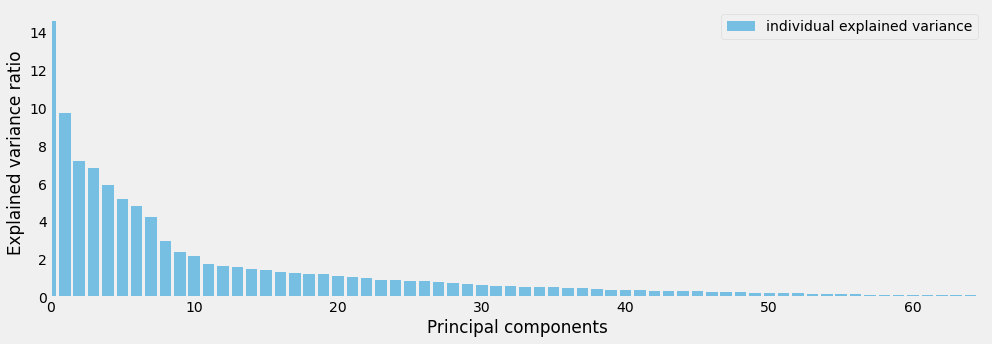

In [79]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(14, 5))

    plt.bar(range(len(var_exp)), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.xlim(0,65,1)
    plt.grid()
    plt.tight_layout()

This graph show us that from the 108 features we have, less than half explained the variance ratio of the data. In other words, with less features we can represent close to the same amount of data.

Number of components needed to reach 95.0% of the data variance:44


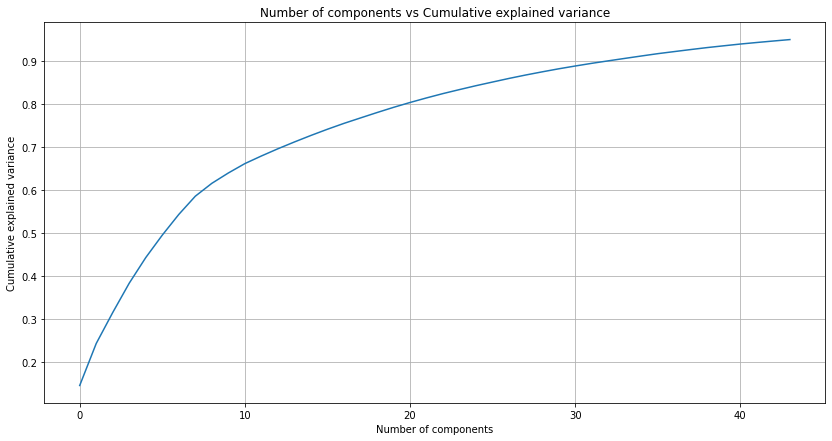

In [80]:
from sklearn.decomposition import PCA # using sklear decomposition library we can perform more easily the feature reduction
cumulative_var = 0.95
pca = PCA(cumulative_var).fit(df_dum_std)
print("Number of components needed to reach {0}% of the data variance:{1}".format(cumulative_var*100,pca.n_components_))
plt.figure(figsize=(14,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlim(0,100,1)
plt.title('Number of components vs Cumulative explained variance')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

In [81]:
pca = PCA(0.95).fit(df_dum_std)
print("Count of PCA features:",len(pca.explained_variance_ratio_))
print("Percentage reached", round(sum(pca.explained_variance_ratio_)*100,2))
#print(pca.singular_values_)

Count of PCA features: 44
Percentage reached 95.05


The calculations and graphics done before, tell us that with only 46 PCA features we can represent 95% of the data provided by the 134 features.

In [82]:
X_pca = pca.fit_transform(df_dum_std)

In [83]:
X_pca.shape

(101766, 44)

In [84]:
# PCA transformating generates an array without column names
col_pca = ['pc_{0}'.format(i+1) for i in range(X_pca.shape[1])] # list of column names
df_pca = pd.DataFrame(X_pca, columns = col_pca) # new data frame creation
df_pca['readmitted'] = y # target variable
df_pca['readmitted_bi'] = y_binary # target variable

In [85]:
# New data frame for modeling
df_pca.shape

(101766, 46)

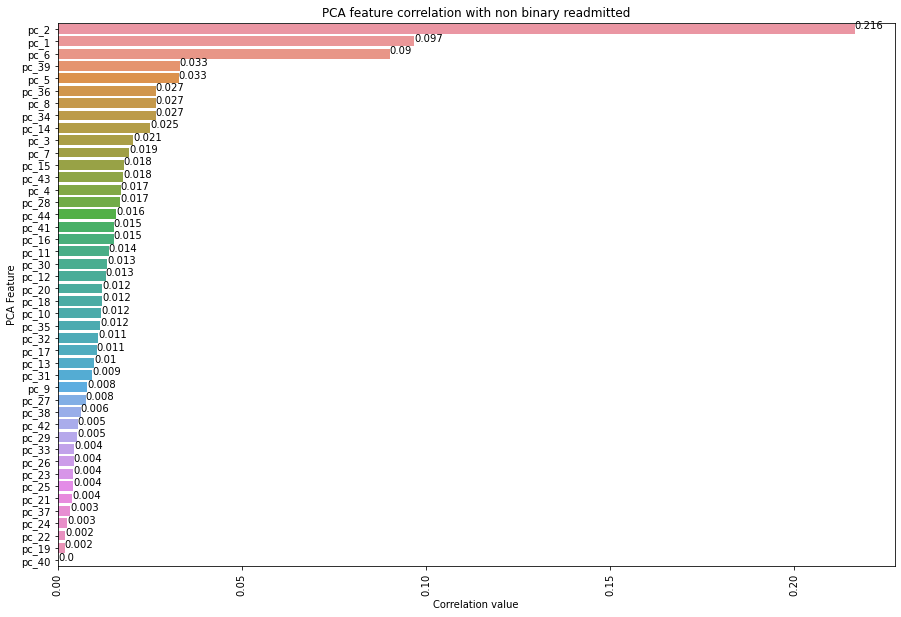

In [89]:
#plt.figure(figsize=(15,7))
corr=df_pca.iloc[:,:-1].corr()['readmitted'].abs().sort_values(ascending=False)

plt.figure(figsize=(15,10))

sns.barplot(y=corr.index[1:], x=corr.values[1:], orient='h')
for index, correlation in enumerate(corr[1:]): 
    plt.text(correlation, index, str(round(correlation, 3)))
    
plt.xticks(rotation=90)
plt.title("PCA feature correlation with non binary readmitted")
plt.xlabel("Correlation value")
plt.ylabel("PCA Feature")
plt.show()

The PC_2 feature is the highest correlated to the target variable. This could represent a tendency for the models to give to it more priority. 

<a href="#0"><font size="1">Back to contents</font></a>

### 3. Modeling<a id="modeling"></a>

In [90]:
# Models
from sklearn.linear_model import LogisticRegression # Logistic regression
from sklearn.tree import DecisionTreeClassifier # Decision tree classifier
from sklearn.ensemble import RandomForestClassifier # Random forest classifier

# Train and test splitting
from sklearn.model_selection import train_test_split

# Metrics
import sklearn.metrics as metrics # Metrics to evaluate models
from sklearn.metrics import confusion_matrix # matrix with false positives, false negatives ... 

# Cross validation
from sklearn.model_selection import cross_val_score # To be sure the model performs well in different iterations of the data 
# Grid search - optimization
from sklearn.model_selection import GridSearchCV

### Benchmark model: Logistic regression with numerical columns 

In [91]:
X_bench = df[num_cols[4::]] # data set with only 8 numeric features
y_bench = df['readmitted_reg'] # target variable in binary form
# Standardization of the data
X_bench_std = X_bench.copy()
X_bench_std[num_cols[4::]] = StandardScaler().fit_transform(X_bench) 
# Standardization it is used to normalize the data in order to have proportional weights once feed into the model.

In [95]:
# Create train and test sets to train and measure the performance of the model
X_trainB, X_testB, y_trainB, y_testB = train_test_split(X_bench_std, y_bench, test_size=0.33, random_state=42) #, stratify=y_bench)
# Create logistic regression model
clf_logit_bench = LogisticRegression(random_state=0).fit(X_trainB, y_trainB)
# Calculate predictions
y_train_predB = clf_logit_bench.predict(X_trainB)
y_test_predB = clf_logit_bench.predict(X_testB)
print(f"Accuracy training score: {metrics.accuracy_score(y_trainB, y_train_predB)}") 
print(f"Accuracy testing score: {metrics.accuracy_score(y_testB, y_test_predB)}")
print(f"Validation score per folio: {cross_val_score(clf_logit_bench, X_trainB, y_trainB, cv=10)}")
print(f"Average validation score: {round(cross_val_score(clf_logit_bench, X_trainB, y_trainB, cv=10).mean(),2)}")

Accuracy training score: 0.6155053312409251
Accuracy testing score: 0.6175148140428193
Validation score per folio: [0.62443173 0.61577944 0.60140783 0.6111763  0.62158991 0.61953652
 0.62232326 0.61352303 0.6136697  0.61542974]
Average validation score: 0.62


The bench mark model classify correctly 62% of the testing data. It is a lot better than flip a coin, it is a decent first approach, although this model simplifies the target variable. 

### Logistic regression model with data frame without PCA transformation - 108 features

In [96]:
print(df_dum_std.shape)
df_dum_std['readmitted'] = y # target variable
df_dum_std['readmitted_bi'] = y_binary # target variable

(101766, 108)


In [97]:
# Create train and test sets to train and measure the performance of the model
X_train, X_test, y_train, y_test = train_test_split(df_dum_std.iloc[:,:-2], df_dum_std.readmitted_bi, test_size=0.33,
                                                    random_state=42, stratify= df_dum_std.readmitted_bi)
# Create logistic regression model
clf_logit = LogisticRegression(random_state=0).fit(X_train, y_train)
# Calculate predictions
y_train_pred = clf_logit.predict(X_train)
y_test_pred = clf_logit.predict(X_test)
print(f"Accuracy training score: {metrics.accuracy_score(y_train, y_train_pred)}") 
print(f"Accuracy testing score: {metrics.accuracy_score(y_test, y_test_pred)}")
print(f"Validation score per folio: {cross_val_score(clf_logit, X_train, y_train, cv=10)}")
print(f"Average validation score: {round(cross_val_score(clf_logit, X_train, y_train, cv=10).mean(),2)}") 

Accuracy training score: 0.6236305237375885
Accuracy testing score: 0.6229639996426763
Validation score per folio: [0.62428509 0.61871242 0.61856577 0.62056322 0.62511    0.6350836
 0.62320329 0.61645644 0.62217659 0.62246993]
Average validation score: 0.62


The model accurately predicts 62% of the testing data. It is practically the same than the benchmark.

### Logistic regression model with data frame after PCA transformation - 44 features and binary target

In [98]:
# Create train and test sets to train and measure the performance of the model
X_train, X_test, y_train, y_test = train_test_split(df_pca.iloc[:,:-2], df_pca.readmitted_bi, test_size=0.33, random_state=42,
                                                        stratify= df_pca.readmitted_bi)
# Create logistic regression model
clf_logit = LogisticRegression(random_state=0).fit(X_train, y_train)
# Calculate predictions
y_train_pred = clf_logit.predict(X_train)
y_test_pred = clf_logit.predict(X_test)
print(f"Accuracy training score: {metrics.accuracy_score(y_train, y_train_pred)}") 
print(f"Accuracy testing score: {metrics.accuracy_score(y_test, y_test_pred)}")
cross = cross_val_score(clf_logit, X_train, y_train, cv=10)
print(f"Validation score per folio: {cross}")
print(f"Average validation score: {round(cross.mean(),2)}")

Accuracy training score: 0.6212838977457724
Accuracy testing score: 0.6191525474198255
Validation score per folio: [0.61929902 0.62237865 0.61812582 0.61674978 0.62026987 0.63068348
 0.62290994 0.61029627 0.6186565  0.62070989]
Average validation score: 0.62


The model accurately predicts 62% of the testing data. It is practically the same that the created without the feature processing. 

### Decision tree classifier model with data frame after PCA transformation with binary target

In [99]:
# Create decision tree classifier model
clf = DecisionTreeClassifier(max_depth= 5,random_state=0).fit(X_train, y_train)
# Calculate predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print(f"Accuracy training score: {metrics.accuracy_score(y_train, y_train_pred)}") 
print(f"Accuracy testing score: {metrics.accuracy_score(y_test, y_test_pred)}")
cross = cross_val_score(clf, X_train, y_train, cv=10)
print(f"Validation score per folio: {cross}")
print(f"Average validation score: {round(cross.mean(),2)}")

Accuracy training score: 0.6212985641582213
Accuracy testing score: 0.6202245183575023
Validation score per folio: [0.61563279 0.61709928 0.6147529  0.612643   0.61689645 0.63141684
 0.61454972 0.60941625 0.61880317 0.61161631]
Average validation score: 0.62


The decision tree model accurately predicts 61% of the testing data. It performs a little worst, but the hyperparameters are not optimized.

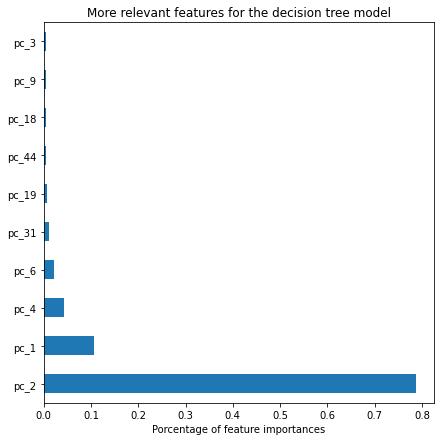

In [100]:
# Feature importance for the classifier.
feature_importance = clf.feature_importances_
feat_importances = pd.Series(feature_importance, index=X_train.columns)
feat_importances = feat_importances.nlargest(10)
feat_importances.plot(kind='barh' , figsize=(7,7)) 
plt.xlabel("Porcentage of feature importances")
plt.title("More relevant features for the decision tree model")
plt.show()

In [101]:
parameters = {'criterion':('entropy', 'gini'), 'max_depth':[3,4,5,6,7,8,9,10]}
# Grid search, allow to create multiple models, that we can evaluate and choose
clf = GridSearchCV(DecisionTreeClassifier(random_state=0), parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ('entropy', 'gini'),
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]})

In [102]:
results_df = pd.DataFrame(clf.cv_results_) # create a result with the different models
results_df = results_df.sort_values(by=['rank_test_score']) # sort the models by scores
results_df = (results_df.set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values())))
              .rename_axis('model')) 
results_df[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']]

,params,rank_test_score,mean_test_score,std_test_score
model,,,,
entropy_4,"{'criterion': 'entropy', 'max_depth': 4}",1,0.62,0.00
gini_4,"{'criterion': 'gini', 'max_depth': 4}",2,0.62,0.00
entropy_5,"{'criterion': 'entropy', 'max_depth': 5}",3,0.62,0.00
gini_5,"{'criterion': 'gini', 'max_depth': 5}",4,0.61,0.00
entropy_6,"{'criterion': 'entropy', 'max_depth': 6}",5,0.61,0.01
gini_6,"{'criterion': 'gini', 'max_depth': 6}",6,0.61,0.01
entropy_3,"{'criterion': 'entropy', 'max_depth': 3}",7,0.61,0.00
gini_3,"{'criterion': 'gini', 'max_depth': 3}",7,0.61,0.00
entropy_7,"{'criterion': 'entropy', 'max_depth': 7}",9,0.61,0.00


Using multiple hyperparameters did not increase to much the accuracy of the model, maybe a more powerfull model would perform better, a model that takes in to account more features and not only "PC_2".

### Random Forest classifier model with data frame after PCA transformation with binary target

In [103]:
# Create the Random Forest Classifier model
clf = RandomForestClassifier(max_depth= 5,random_state=0).fit(X_train, y_train)
# Calculate predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print(f"Accuracy training score: {metrics.accuracy_score(y_train, y_train_pred)}") 
print(f"Accuracy testing score: {metrics.accuracy_score(y_test, y_test_pred)}")
cross = cross_val_score(clf, X_train, y_train, cv=5)
print(f"Validation score per folio: {cross}")
print(f"Average validation score: {round(cross.mean(),2)}")

Accuracy training score: 0.619743924438643
Accuracy testing score: 0.6183783461870589
Validation score per folio: [0.61421134 0.61201144 0.62286427 0.61528307 0.61330302]
Average validation score: 0.62


The random forest model accurately predicts 61% of the testing data. It performs a little worst, but the hyperparameters are not optimized.

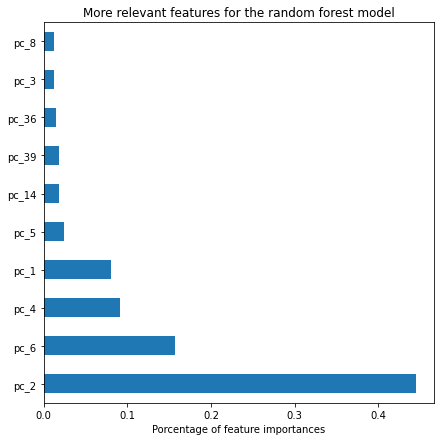

In [104]:
# Feature importance for the classifier.
feature_importance = clf.feature_importances_
feat_importances = pd.Series(feature_importance, index=X_train.columns)
feat_importances = feat_importances.nlargest(10)
feat_importances.plot(kind='barh' , figsize=(7,7)) 
plt.xlabel("Porcentage of feature importances")
plt.title("More relevant features for the random forest model")
plt.show()

The feature importance graphic shows that for the random forest model the importance of other features is greater and less unbalanced towards PC_2.

In [105]:
parameters = {'criterion':('entropy', 'gini'), 'max_depth':[3,5,7,9]}
# Grid search, allow to create multiple models, that we can evaluate and choose
clf = GridSearchCV(DecisionTreeClassifier(random_state=0), parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ('entropy', 'gini'),
                         'max_depth': [3, 5, 7, 9]})

In [106]:
results_df = pd.DataFrame(clf.cv_results_) # create a result with the different models
results_df = results_df.sort_values(by=['rank_test_score']) # sort the models by scores
results_df = (results_df.set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values())))
              .rename_axis('model')) 
results_df[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']]

,params,rank_test_score,mean_test_score,std_test_score
model,,,,
entropy_5,"{'criterion': 'entropy', 'max_depth': 5}",1,0.62,0.00
gini_5,"{'criterion': 'gini', 'max_depth': 5}",2,0.61,0.00
entropy_3,"{'criterion': 'entropy', 'max_depth': 3}",3,0.61,0.00
gini_3,"{'criterion': 'gini', 'max_depth': 3}",3,0.61,0.00
entropy_7,"{'criterion': 'entropy', 'max_depth': 7}",5,0.61,0.00
gini_7,"{'criterion': 'gini', 'max_depth': 7}",6,0.61,0.00
entropy_9,"{'criterion': 'entropy', 'max_depth': 9}",7,0.61,0.01
gini_9,"{'criterion': 'gini', 'max_depth': 9}",8,0.60,0.00


Using multiple hyperparameters did not increase to much the accuracy of the model, even though this model takes in to account more features and not only "PC_2".

### Random forest classifier model with data frame without PCA transformation - 108 features

In [108]:
# Create train and test sets to train and measure the performance of the model
X_train, X_test, y_train, y_test = train_test_split(df_dum_std.iloc[:,:-2], df_dum_std.readmitted_bi, test_size=0.33,
                                                    random_state=42, stratify= df_dum_std.readmitted_bi)
# Create the Random Forest Classifier model
clf = RandomForestClassifier(max_depth= 5,random_state=0).fit(X_train, y_train)
# Calculate predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print(f"Accuracy training score: {metrics.accuracy_score(y_train, y_train_pred)}") 
print(f"Accuracy testing score: {metrics.accuracy_score(y_test, y_test_pred)}")
cross = cross_val_score(clf, X_train, y_train, cv=5)
print(f"Validation score per folio: {cross}")
print(f"Average validation score: {round(cross.mean(),2)}")

Accuracy training score: 0.6222518809673966
Accuracy testing score: 0.6227257838787482
Validation score per folio: [0.61619124 0.61516463 0.62572413 0.61689645 0.61814315]
Average validation score: 0.62


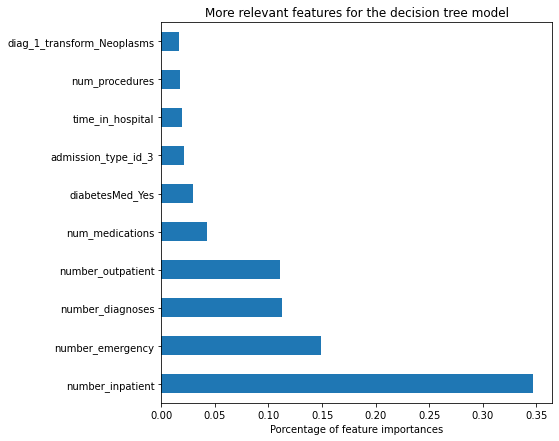

In [109]:
# Feature importance for the classifier.
feature_importance = clf.feature_importances_
feat_importances = pd.Series(feature_importance, index=X_train.columns)
feat_importances = feat_importances.nlargest(10)
feat_importances.plot(kind='barh' , figsize=(7,7)) 
plt.xlabel("Porcentage of feature importances")
plt.title("More relevant features for the decision tree model")
plt.show()

The top 5 feature importance goes to 5 numeric variables. This explain why the models are so close to each other, taking into account that the bench mark model only uses the numerical features.

### Random Forest classifier model with data frame after PCA transformation with non binary target

In [110]:
# Create train and test sets to train and measure the performance of the model
X_train, X_test, y_train, y_test = train_test_split(df_pca.iloc[:,:-2], df_pca.readmitted, test_size=0.33, random_state=42,
                                                        stratify= df_pca.readmitted)

In [111]:
# Create the Random Forest Classifier model
clf = RandomForestClassifier(max_depth= 5,random_state=0).fit(X_train, y_train)
# Calculate predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print(f"Accuracy training score: {metrics.accuracy_score(y_train, y_train_pred)}") 
print(f"Accuracy testing score: {metrics.accuracy_score(y_test, y_test_pred)}")
cross = cross_val_score(clf, X_train, y_train, cv=5)
print(f"Validation score per folio: {cross}")
print(f"Average validation score: {round(cross.mean(),2)}")

Accuracy training score: 0.5662115190003373
Accuracy testing score: 0.5603728076705476
Validation score per folio: [0.55796729 0.56207377 0.56339371 0.55852156 0.56438838]
Average validation score: 0.56


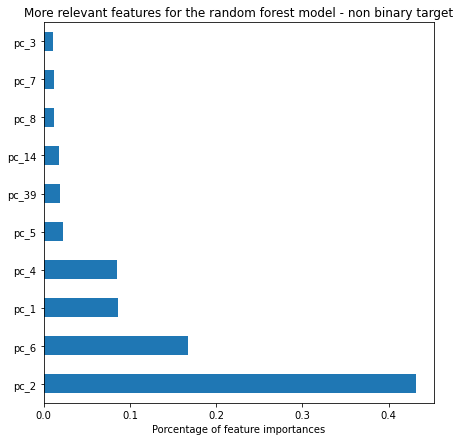

In [112]:
# Feature importance for the classifier.
feature_importance = clf.feature_importances_
feat_importances = pd.Series(feature_importance, index=X_train.columns)
feat_importances = feat_importances.nlargest(10)
feat_importances.plot(kind='barh' , figsize=(7,7)) 
plt.xlabel("Porcentage of feature importances")
plt.title("More relevant features for the random forest model - non binary target")
plt.show()

Trying to predict tree variables reduces in 6% the accuracy of the model. Using a model, that takes into account many features.

<a href="#0"><font size="1">Back to contents</font></a>

### 4. Conclusions<a id="con"></a>

1. At first glance the models that included the information from categorical variables did not performe very well. But this can be explain by the fact that many important features as weight were incomplete. Mainly the weight that is highly correlated to the diabetes and many diseases, had a lot of missing values. 
2. The numerical features were more correlated to the target variable than the categorical features. In a future is suggested to make groups of features and analyze the feature importance to the model. With the goal of selecting the ones more correlated. Diabetes medication was one the categorical variable with high importance to the models, the next step would be start with this feature and combining it to more. For this it is important to use the statsmodels library and make regression and null hypothesis to analyze p-values between features.  
3. A causality analysis could help to understand better the readmission rates, due to the fact that the inpatients were in the hospital by many diseases and many diagnoses through different years and different environments (in different states). As is stablished in the paper "our analysis showed that the profile of readmission differed significantly in patients where Hba1c was checked in the setting of a primary diabetes diagnosis, when compared to those with a primary circulatory disorder. While readmission rates remained the highest for patients with circulatory diagnoses"
4. Using aggregation allows to obtained information from features with high variances and incorporate them to the models. Additionally, using principal component analysis we can represent many features in few transformed ones, this can help to reduce the consumption of resources in projects with many records.  

5. Additionally a nearest neighbors technique was utilized with the transformed data set, the results shown that the amount of clusters with the best data differentiation is 12. And if we use a number of clusters of 3 and compare with the target variable the accuracy it is close to 50%, really low.  

<a href="#0"><font size="1">Back to contents</font></a>

### 5. Additional: Clustering<a id="cluster"></a>

In [116]:
# Library used for clustering
from sklearn.cluster import KMeans

For clustering it was used the data set after being transformed with the principal components. The model used for clustering was K nearest neighbors and the evaluation method used was the Elbow examination. 

In [114]:
def clustering(X):    
    # List - Sum of squared distances 
    Sum_of_squared_distances = []
    # Create a list with possible number of clusters
    K = np.arange(2,20)
    for k in K:
        # Create and train the model
        km = KMeans(n_clusters=k, random_state=0).fit(X)
        # Calculate medium distance and add it to the sum of squared distances list
        total_distance = km.inertia_
        medium_distance = np.divide(total_distance, X.shape[0])
        Sum_of_squared_distances.append(medium_distance)
        
    # Graph medium distances against number of clusters
    plt.figure(figsize = (10,10))
    plt.plot(K, Sum_of_squared_distances, lw=3)
    plt.scatter(K, Sum_of_squared_distances,s=55,c='r')
    plt.xlabel('Number of clusters K')
    plt.ylabel('Inertia ')
    plt.title('Elbow method')
    plt.show()
    
    # Elbow method to determine the number of clusters that differentiate better the data
    slopes = (np.array(Sum_of_squared_distances[1:]) - np.array(Sum_of_squared_distances[:-1]))\
             / (K[1:] - K[:-1])
    slope_relationship = slopes[1:]/ slopes[:-1]
    chosen_k = K[np.argmin(slope_relationship) + 1]
    
    # Train the modle with the chosen K
    km = KMeans(n_clusters=chosen_k, random_state=0).fit(X)
    
    labels = km.labels_ # cluster labels
    centroids = km.cluster_centers_ # centroids
    
    return chosen_k, labels

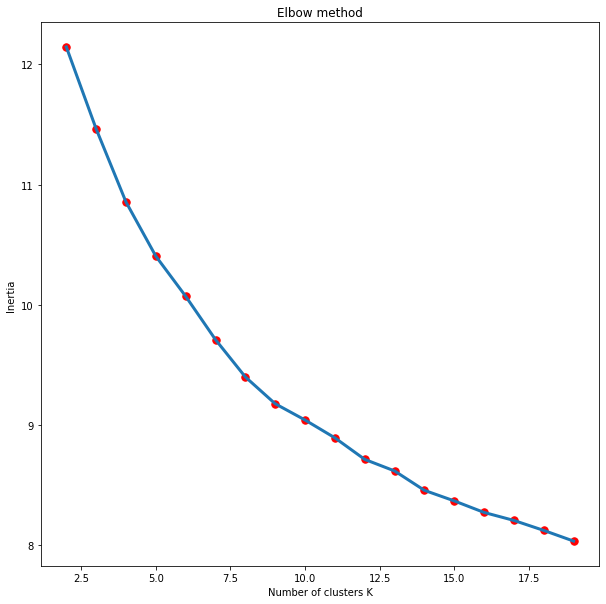

In [117]:
chosen_k, labels = clustering(df_pca.iloc[:,:-2])

In [118]:
chosen_k

12

12 clusters was the number of clusters calculated that best separates or differentiates the data.  

In [120]:
df_pca['Cluster']= labels
df_pca['Cluster'].value_counts()

10    17646
9     14863
1     12963
0     12110
6     11157
2      9681
7      9015
3      5722
4      5083
11     2253
8      1240
5        33
Name: Cluster, dtype: int64

The number of records per cluster it is shown in the past cell.

The best number of clusters that separates the data is 12 but the target variable was filled taking into account 3 conditions, so it is important to compare how is the distribution of the data with a number of clusters equal to 3.

In [127]:
# Train the modle with the chosen K
km = KMeans(n_clusters=3, random_state=0).fit(df_pca.iloc[:,:-3])

labels_ = km.labels_ # cluster labels
df_pca['Cluster_3']= labels_

In [128]:
print(df_pca['readmitted'].value_counts())
print(df_pca['Cluster_3'].value_counts())

0    54864
1    35545
2    11357
Name: readmitted, dtype: int64
1    60897
2    31288
0     9581
Name: Cluster_3, dtype: int64


In [129]:
# Map cluster 3 names in order to have the equivalent proportions for comparisson
df_pca['Cluster_3']= df_pca['Cluster_3'].map({1:0,2:1,0:2})

In [130]:
print(df_pca['readmitted'].value_counts())
print(df_pca['Cluster_3'].value_counts())

0    54864
1    35545
2    11357
Name: readmitted, dtype: int64
0    60897
1    31288
2     9581
Name: Cluster_3, dtype: int64


In [131]:
print(f"Accuracy score: {metrics.accuracy_score(df_pca['readmitted'], df_pca['Cluster_3'])}") 

Accuracy score: 0.49090069374840317
